In [2]:
# VERIFICAÇÃO DE GPU
# Conectar ao ambiente de execução com a GPU Tesla T4 do google colab
!nvidia-smi

Mon Nov 17 22:11:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# 2. IMPORTS
import os
import subprocess
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [4]:
# 2. GERAÇÃO DE DADOS (N=50 Milhões)

# N = 1000000  # Muito pequeno
N = 50000000 # 50 milhões de pontos
K = 16       # 16 centroides
MAX_ITER = 100
EPSILON = 1e-6

print(f"Gerando N={N} pontos e K={K} centroides...")

# Gerar K centroides iniciais (distribuídos entre 0 e K*10)
initial_centroids = np.linspace(5, K*10 - 5, K) + np.random.rand(K) * 2 - 1
np.savetxt("centroides_iniciais.csv", initial_centroids, fmt='%.6f')

# Gerar N pontos agrupados em torno dos K centroides
points_per_cluster = N // K
all_points = []
for i in range(K):
    # Gera pontos com um desvio padrão de 2.0 em torno do centroide
    cluster_points = np.random.normal(loc=initial_centroids[i], scale=2.0, size=points_per_cluster)
    all_points.append(cluster_points)

# Ajusta se N não for perfeitamente divisível por K
remaining_points = N - (points_per_cluster * K)
if remaining_points > 0:
    cluster_points = np.random.normal(loc=initial_centroids[0], scale=2.0, size=remaining_points)
    all_points.append(cluster_points)

final_data = np.concatenate(all_points)
np.random.shuffle(final_data) # Embaralha os pontos

np.savetxt("dados.csv", final_data, fmt='%.6f')

print(f"Arquivos 'dados.csv' (N={len(final_data)}) e 'centroides_iniciais.csv' (K={K}) gerados.")

Gerando N=50000000 pontos e K=16 centroides...
Arquivos 'dados.csv' (N=50000000) e 'centroides_iniciais.csv' (K=16) gerados.


In [5]:
# Etapa 0: K-means sequencial
%%writefile kmeans_1d_naive.c

/*
  kmeans_1d_naive.c
  MODIFICADO para "Entrega 2":
  - Usa omp_get_wtime() para medição de tempo de parede (requer -fopenmp na compilação)
  - Imprime SSE por iteração
  - Imprime linha "FINAL_DATA" para parsing
*/

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <omp.h> // Para omp_get_wtime()

/* ---------- Funções de Leitura/Escrita CSV (Idênticas às suas) ---------- */
static int count_rows(const char *path){
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); exit(1); }
    int rows=0; char line[8192];
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(!only_ws) rows++;
    }
    fclose(f);
    return rows;
}

static double *read_csv_1col(const char *path, int *n_out){
    int R = count_rows(path);
    if(R<=0){ fprintf(stderr,"Arquivo vazio: %s\n", path); exit(1); }
    double *A = (double*)malloc((size_t)R * sizeof(double));
    if(!A){ fprintf(stderr,"Sem memoria para %d linhas\n", R); exit(1); }
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); free(A); exit(1); }
    char line[8192]; int r=0;
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(only_ws) continue;
        const char *delim = ",; \t";
        char *tok = strtok(line, delim);
        if(!tok){ fprintf(stderr,"Linha %d sem valor em %s\n", r+1, path); free(A); fclose(f); exit(1); }
        A[r] = atof(tok);
        r++;
        if(r>R) break;
    }
    fclose(f); *n_out = R; return A;
}

static void write_assign_csv(const char *path, const int *assign, int N){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int i=0;i<N;i++) fprintf(f, "%d\n", assign[i]);
    fclose(f);
}

static void write_centroids_csv(const char *path, const double *C, int K){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int c=0;c<K;c++) fprintf(f, "%.6f\n", C[c]);
    fclose(f);
}

/* ---------- k-means 1D (Sequencial) ---------- */
static double assignment_step_1d(const double *X, const double *C, int *assign, int N, int K){
    double sse = 0.0;
    for(int i=0;i<N;i++){
        int best = -1;
        double bestd = 1e300;
        for(int c=0;c<K;c++){
            double diff = X[i] - C[c];
            double d = diff*diff;
            if(d < bestd){ bestd = d; best = c; }
        }
        assign[i] = best;
        sse += bestd;
    }
    return sse;
}

static void update_step_1d(const double *X, double *C, const int *assign, int N, int K){
    double *sum = (double*)calloc((size_t)K, sizeof(double));
    int *cnt = (int*)calloc((size_t)K, sizeof(int));
    if(!sum || !cnt){ fprintf(stderr,"Sem memoria no update\n"); exit(1); }
    for(int i=0;i<N;i++){
        int a = assign[i];
        cnt[a] += 1;
        sum[a] += X[i];
    }
    for(int c=0;c<K;c++){
        if(cnt[c] > 0) C[c] = sum[c] / (double)cnt[c];
        else           C[c] = X[0];
    }
    free(sum); free(cnt);
}

static void kmeans_1d(const double *X, double *C, int *assign,
                      int N, int K, int max_iter, double eps,
                      int *iters_out, double *sse_out, double *sse_history)
{
    double prev_sse = 1e300;
    double sse = 0.0;
    int it;
    for(it=0; it<max_iter; it++){
        sse = assignment_step_1d(X, C, assign, N, K);
        if (sse_history) sse_history[it] = sse;

        // Imprime SSE para validação
        // (Usamos stderr para não poluir stdout que será lido pelo script)
        fprintf(stderr, "SSE_ITER_SEQ: %d %.6f\n", it, sse);

        double rel = fabs(sse - prev_sse) / (prev_sse > 0.0 ? prev_sse : 1.0);
        if(rel < eps && it > 0){ it++; break; } // Adicionado it > 0
        update_step_1d(X, C, assign, N, K);
        prev_sse = sse;
    }
    *iters_out = it;
    *sse_out = sse;
}

/* ---------- main ---------- */
int main(int argc, char **argv){
    if(argc < 3){
        printf("Uso: %s dados.csv centroides_iniciais.csv [max_iter=50] [eps=1e-4] [assign.csv] [centroids.csv]\n", argv[0]);
        return 1;
    }
    const char *pathX = argv[1];
    const char *pathC = argv[2];
    int max_iter = (argc>3)? atoi(argv[3]) : 50;
    double eps   = (argc>4)? atof(argv[4]) : 1e-4;
    const char *outAssign   = (argc>5)? argv[5] : NULL;
    const char *outCentroid = (argc>6)? argv[6] : NULL;

    int N=0, K=0;
    double *X = read_csv_1col(pathX, &N);
    double *C = read_csv_1col(pathC, &K);
    int *assign = (int*)malloc((size_t)N * sizeof(int));
    if(!assign){ fprintf(stderr,"Sem memoria para assign\n"); free(X); free(C); return 1; }

    // Aloca histórico de SSE para validação
    double *sse_history = (double*)malloc((size_t)max_iter * sizeof(double));

    // Medição de tempo com omp_get_wtime()
    double t0 = omp_get_wtime();
    int iters = 0; double sse = 0.0;
    kmeans_1d(X, C, assign, N, K, max_iter, eps, &iters, &sse, sse_history);
    double t1 = omp_get_wtime();
    double ms = 1000.0 * (t1 - t0);

    fprintf(stderr, "K-means 1D (Sequencial - Baseline)\n");
    fprintf(stderr, "N=%d K=%d max_iter=%d eps=%g\n", N, K, max_iter, eps);
    fprintf(stderr, "Iterações: %d | SSE final: %.6f | Tempo: %.1f ms\n", iters, sse, ms);

    // Saída principal para parsing
    printf("FINAL_DATA: Time=%.1f SSE=%.6f Iters=%d N=%d K=%d\n", ms, sse, iters, N, K);

    // Saída de SSE por iteração para parsing
    for(int i=0; i<iters; i++) {
        printf("SSE_HISTORY: %d %.6f\n", i, sse_history[i]);
    }

    write_assign_csv(outAssign, assign, N);
    write_centroids_csv(outCentroid, C, K);

    free(assign); free(X); free(C); free(sse_history);
    return 0;
}

Overwriting kmeans_1d_naive.c


In [6]:
%%writefile kmeans_1d_cuda.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <omp.h> // Para omp_get_wtime()
#include <cuda_runtime.h>

/* ---------- Funções de Leitura/Escrita CSV (Idênticas às sequenciais) ---------- */
static int count_rows(const char *path){
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); exit(1); }
    int rows=0; char line[8192];
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(!only_ws) rows++;
    }
    fclose(f);
    return rows;
}

static double *read_csv_1col(const char *path, int *n_out){
    int R = count_rows(path);
    if(R<=0){ fprintf(stderr,"Arquivo vazio: %s\n", path); exit(1); }
    double *A = (double*)malloc((size_t)R * sizeof(double));
    if(!A){ fprintf(stderr,"Sem memoria para %d linhas\n", R); exit(1); }
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); free(A); exit(1); }
    char line[8192]; int r=0;
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(only_ws) continue;
        const char *delim = ",; \t";
        char *tok = strtok(line, delim);
        if(!tok){ fprintf(stderr,"Linha %d sem valor em %s\n", r+1, path); free(A); fclose(f); exit(1); }
        A[r] = atof(tok);
        r++;
        if(r>R) break;
    }
    fclose(f); *n_out = R; return A;
}

static void write_centroids_csv(const char *path, const double *C, int K){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int c=0;c<K;c++) fprintf(f, "%.6f\n", C[c]);
    fclose(f);
}

// Escrita de assign.csv (opcional) não é mais necessária para o loop,
// mas pode ser chamada no final se for preciso (não implementado aqui para performance)
static void write_assign_csv(const char *path, const int *assign, int N){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int i=0;i<N;i++) fprintf(f, "%d\n", assign[i]);
    fclose(f);
}


/* ---------- KERNEL CUDA: Assignment, Update (Atomics) e Redução de SSE ---------- */
/*
  Este kernel implementa a "Opção B" do PDF.
  - 1 thread por ponto X[i]
  - Encontra o centróide 'best_c' mais próximo
  - Usa atomicAdd para:
    1. Somar o SSE do ponto ao d_sse_total
    2. Somar o valor X[i] ao d_sum[best_c]
    3. Incrementar o contador d_cnt[best_c]

  NOTA: atomicAdd para double (64-bit) requer Compute Capability 6.0+
  (GPUs T4, P100, V100 do Colab funcionam; K80 antigo não)
*/
__global__ void assignment_and_update_kernel(
    const double *d_X, const double *d_C,
    double *d_sum, unsigned long long *d_cnt, double *d_sse_total,
    int N, int K)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= N) return;

    int best_c = -1;
    double best_d = 1e300;

    for (int c = 0; c < K; c++) {
        double diff = d_X[i] - d_C[c];
        double d = diff * diff;
        if (d < best_d) {
            best_d = d;
            best_c = c;
        }
    }

    // CORREÇÃO DO BUG: Apenas executa o atomic se 'best_c' for válido.
    if (best_c != -1) {
        atomicAdd(d_sse_total, best_d);
        atomicAdd(&d_sum[best_c], d_X[i]);
        atomicAdd(&d_cnt[best_c], 1);
    }
}


/* ---------- FUNÇÃO HOST: K-means (Lógica principal CUDA) ---------- */
static void kmeans_1d_cuda(const double *h_X, double *h_C,
                           int N, int K, int max_iter, double eps, int block_size,
                           int *iters_out, double *sse_out, double *sse_history,
                           float *ms_kernel_total, float *ms_h2d_total, float *ms_d2h_total)
{
    // 1. Alocar memória do Device (GPU)
    double *d_X, *d_C, *d_sum, *d_sse_total;
    unsigned long long *d_cnt;

    cudaMalloc(&d_X, (size_t)N * sizeof(double));
    cudaMalloc(&d_C, (size_t)K * sizeof(double));
    cudaMalloc(&d_sum, (size_t)K * sizeof(double));
    cudaMalloc(&d_cnt, (size_t)K * sizeof(unsigned long long));
    cudaMalloc(&d_sse_total, sizeof(double));

    // 2. Alocar memória do Host (CPU) para resultados
    double *h_sum = (double*)malloc((size_t)K * sizeof(double));
    unsigned long long *h_cnt = (unsigned long long*)malloc((size_t)K * sizeof(unsigned long long));
    double h_sse_total;

    // 3. Criar eventos CUDA para medição de tempo
    cudaEvent_t start_h2d, stop_h2d;
    cudaEvent_t start_kernel, stop_kernel;
    cudaEvent_t start_d2h, stop_d2h;
    cudaEvent_t start_host, stop_host;
    cudaEventCreate(&start_h2d); cudaEventCreate(&stop_h2d);
    cudaEventCreate(&start_kernel); cudaEventCreate(&stop_kernel);
    cudaEventCreate(&start_d2h); cudaEventCreate(&stop_d2h);
    cudaEventCreate(&start_host); cudaEventCreate(&stop_host);

    *ms_kernel_total = 0.0f;
    *ms_h2d_total = 0.0f;
    *ms_d2h_total = 0.0f;
    float ms_host_total = 0.0f;
    float ms_iter;

    // 4. Copiar dados iniciais (X) para a GPU (H2D)
    cudaEventRecord(start_h2d);
    cudaMemcpy(d_X, h_X, (size_t)N * sizeof(double), cudaMemcpyHostToDevice);
    cudaEventRecord(stop_h2d);
    cudaEventSynchronize(stop_h2d);
    cudaEventElapsedTime(&ms_iter, start_h2d, stop_h2d);
    *ms_h2d_total += ms_iter;

    // 5. Loop de Iteração (K-means)
    double prev_sse = 1e300;
    double sse = 0.0;
    int it;

    int num_blocks = (N + block_size - 1) / block_size;

    for (it = 0; it < max_iter; it++) {
        // --- Início: Medição H2D (C) ---
        cudaEventRecord(start_h2d);
        cudaMemcpy(d_C, h_C, (size_t)K * sizeof(double), cudaMemcpyHostToDevice);
        // Limpar (zerar) os acumuladores na GPU antes do kernel
        cudaMemset(d_sum, 0, (size_t)K * sizeof(double));
        cudaMemset(d_cnt, 0, (size_t)K * sizeof(unsigned long long));
        cudaMemset(d_sse_total, 0, sizeof(double));
        cudaEventRecord(stop_h2d);
        cudaEventSynchronize(stop_h2d);
        cudaEventElapsedTime(&ms_iter, start_h2d, stop_h2d);
        *ms_h2d_total += ms_iter;
        // --- Fim: Medição H2D (C) ---

        // --- Início: Medição Kernel ---
        cudaEventRecord(start_kernel);
        assignment_and_update_kernel<<<num_blocks, block_size>>>(
            d_X, d_C, d_sum, d_cnt, d_sse_total, N, K);
        cudaEventRecord(stop_kernel);
        cudaEventSynchronize(stop_kernel);
        cudaEventElapsedTime(&ms_iter, start_kernel, stop_kernel);
        *ms_kernel_total += ms_iter;
        // --- Fim: Medição Kernel ---

        // --- Início: Medição D2H (Resultados) ---
        // Copia os resultados agregados (pequenos) de volta
        cudaEventRecord(start_d2h);
        cudaMemcpy(&h_sse_total, d_sse_total, sizeof(double), cudaMemcpyDeviceToHost);
        cudaMemcpy(h_sum, d_sum, (size_t)K * sizeof(double), cudaMemcpyDeviceToHost);
        cudaMemcpy(h_cnt, d_cnt, (size_t)K * sizeof(unsigned long long), cudaMemcpyDeviceToHost);
        cudaEventRecord(stop_d2h);
        cudaEventSynchronize(stop_d2h);
        cudaEventElapsedTime(&ms_iter, start_d2h, stop_d2h);
        *ms_d2h_total += ms_iter;
        // --- Fim: Medição D2H ---

        // --- Início: Medição Host (Cálculo final dos centróides) ---
        cudaEventRecord(start_host);
        sse = h_sse_total;

        if (sse_history) sse_history[it] = sse;
        fprintf(stderr, "SSE_ITER_CUDA: %d %.6f\n", it, sse);

        // Verificação de convergência (no Host)
        double rel = fabs(sse - prev_sse) / (prev_sse > 0.0 ? prev_sse : 1.0);

        // Cálculo dos centróides (Loop O(K) - muito rápido)
        for (int c = 0; c < K; c++) {
            if (h_cnt[c] > 0) {
                h_C[c] = h_sum[c] / (double)h_cnt[c];
            } else {
                h_C[c] = h_X[0]; // Estratégia do cluster vazio
            }
        }

        cudaEventRecord(stop_host);
        cudaEventSynchronize(stop_host);
        cudaEventElapsedTime(&ms_iter, start_host, stop_host);
        ms_host_total += ms_iter;
        // --- Fim: Medição Host ---

        if (rel < eps && it > 0) { it++; break; }
        prev_sse = sse;
    }

    // 6. Limpar memória
    cudaFree(d_X); cudaFree(d_C); cudaFree(d_sum); cudaFree(d_cnt); cudaFree(d_sse_total);
    free(h_sum); free(h_cnt);
    cudaEventDestroy(start_h2d); cudaEventDestroy(stop_h2d);
    cudaEventDestroy(start_kernel); cudaEventDestroy(stop_kernel);
    cudaEventDestroy(start_d2h); cudaEventDestroy(stop_d2h);
    cudaEventDestroy(start_host); cudaEventDestroy(stop_host);

    *iters_out = it;
    *sse_out = sse;
}


/* ---------- main ---------- */
int main(int argc, char **argv){
    if(argc < 4){
        printf("Uso: %s dados.csv centroides_iniciais.csv block_size [max_iter=50] [eps=1e-4] [assign.csv] [centroids.csv]\n", argv[0]);
        return 1;
    }
    const char *pathX = argv[1];
    const char *pathC = argv[2];
    int block_size  = atoi(argv[3]);
    int max_iter = (argc>4)? atoi(argv[4]) : 50;
    double eps   = (argc>5)? atof(argv[5]) : 1e-4;
    const char *outAssign   = (argc>6)? argv[6] : NULL;
    const char *outCentroid = (argc>7)? argv[7] : NULL;

    int N=0, K=0;
    double *X = read_csv_1col(pathX, &N);
    // Cria uma cópia dos centróides iniciais,
    // pois a versão sequencial (baseline) modifica o array
    double *C_init = read_csv_1col(pathC, &K);
    int *assign = (int*)malloc((size_t)N * sizeof(int));
    if(!assign){ fprintf(stderr,"Sem memoria para assign\n"); free(X); free(C_init); return 1; }

    double *sse_history = (double*)malloc((size_t)max_iter * sizeof(double));

    // Medição de tempo TOTAL (Wall time)
    double t0 = omp_get_wtime();

    int iters = 0;
    double sse = 0.0;
    float ms_kernel = 0.0f, ms_h2d = 0.0f, ms_d2h = 0.0f, ms_host = 0.0f;

    kmeans_1d_cuda(X, C_init, N, K, max_iter, eps, block_size,
                   &iters, &sse, sse_history,
                   &ms_kernel, &ms_h2d, &ms_d2h);

    double t1 = omp_get_wtime();
    double ms_total = 1000.0 * (t1 - t0);

    // Calcula o tempo de host (agora muito pequeno)
    ms_host = ms_total - (ms_h2d + ms_kernel + ms_d2h);

    fprintf(stderr, "K-means 1D (CUDA - Atomics)\n");
    fprintf(stderr, "N=%d K=%d max_iter=%d eps=%g BlockSize=%d\n", N, K, max_iter, eps, block_size);
    fprintf(stderr, "Iterações: %d | SSE final: %.6f\n", iters, sse);
    fprintf(stderr, "Tempo Total: %.1f ms\n", ms_total);
    fprintf(stderr, "  -> Tempo H2D (Host->Device): %.1f ms (%.1f%%)\n", ms_h2d, 100.0 * ms_h2d / ms_total);
    fprintf(stderr, "  -> Tempo Kernel (Device): %.1f ms (%.1f%%)\n", ms_kernel, 100.0 * ms_kernel / ms_total);
    fprintf(stderr, "  -> Tempo D2H (Device->Host): %.1f ms (%.1f%%)\n", ms_d2h, 100.0 * ms_d2h / ms_total);
    fprintf(stderr, "  -> Tempo Host (Update/SSE): %.1f ms (%.1f%%)\n", ms_host, 100.0 * ms_host / ms_total);


    // Saída principal para parsing
    printf("FINAL_DATA: Time=%.1f SSE=%.6f Iters=%d N=%d K=%d BlockSize=%d Time_H2D=%.1f Time_Kernel=%.1f Time_D2H=%.1f Time_Host=%.1f\n",
           ms_total, sse, iters, N, K, block_size, ms_h2d, ms_kernel, ms_d2h, ms_host);

    // Saída de SSE por iteração para parsing
    for(int i=0; i<iters; i++) {
        printf("SSE_HISTORY: %d %.6f\n", i, sse_history[i]);
    }

    // (Opcional) Gerar assign.csv final
    // Para isso, precisaríamos de um kernel de assignment final.
    // write_assign_csv(outAssign, assign, N);
    write_centroids_csv(outCentroid, C_init, K);

    free(assign); free(X); free(C_init); free(sse_history);
    return 0;
}

Overwriting kmeans_1d_cuda.cu


In [7]:
# 5. COMPILAÇÃO (Corrigida para Opção B - Atomics)

print("--- Compilando Baseline (Sequencial) ---")
# Este comando permanece o mesmo
!gcc -O2 -std=c99 -fopenmp kmeans_1d_naive.c -o kmeans_1d_naive -lm

print("\n--- Compilando CUDA (Opção B) ---")
# CORREÇÃO:
# 1. -Xcompiler="-fopenmp" (para omp_get_wtime)
# 2. -lm (para a biblioteca math, ex: fabs)
# 3. -arch=sm_70 (NECESSÁRIO para atomicAdd em doubles de 64-bit)

!nvcc -O2 kmeans_1d_cuda.cu -o kmeans_1d_cuda -Xcompiler="-fopenmp" -lm -arch=sm_70

print("\n--- Compilação Concluída ---")

--- Compilando Baseline (Sequencial) ---

--- Compilando CUDA (Opção B) ---
kmeans_1d_cuda.cu(251): warning #177-D: variable "outAssign" was declared but never referenced
      const char *outAssign = (argc>6)? argv[6] : 
                  ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

kmeans_1d_cuda.cu(59): warning #177-D: function "write_assign_csv" was declared but never referenced
  static void write_assign_csv(const char *path, const int *assign, int N){
              ^


--- Compilação Concluída ---



--- 1. Executando Baseline Sequencial ---
Baseline (Sequencial): Tempo=3827.2 ms, SSE=191200234.725048, Iters=3

--- 2. Executando Experimentos CUDA ---
Executando CUDA com BlockSize = 128...
  -> Tempo Total: 714.5 ms, SSE: 191200234.725048, Iters: 3
Executando CUDA com BlockSize = 256...
  -> Tempo Total: 654.4 ms, SSE: 191200234.725047, Iters: 3
Executando CUDA com BlockSize = 512...
  -> Tempo Total: 643.1 ms, SSE: 191200234.725049, Iters: 3
Executando CUDA com BlockSize = 1024...
  -> Tempo Total: 649.1 ms, SSE: 191200234.725050, Iters: 3

--- 3. Gerando Gráficos de Análise ---

--- Verificação de Corretude (SSE) ---
SSE Baseline: 191200234.725048
   BlockSize     SSE_final  SSE_Match  Iterations
0        128  1.912002e+08       True           3
1        256  1.912002e+08       True           3
2        512  1.912002e+08       True           3
3       1024  1.912002e+08       True           3


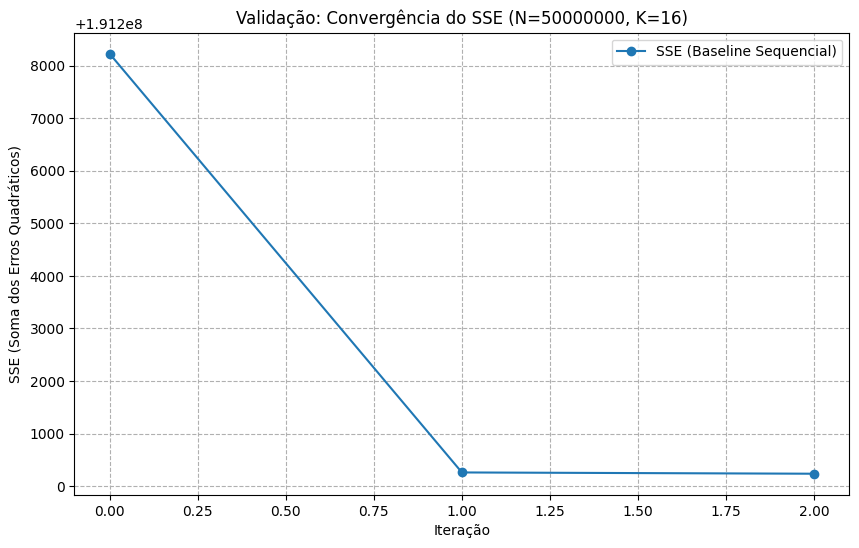

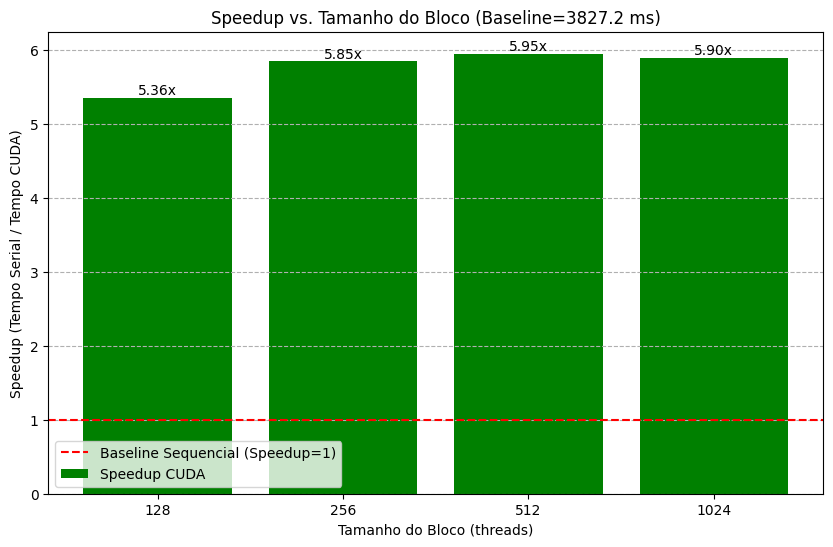

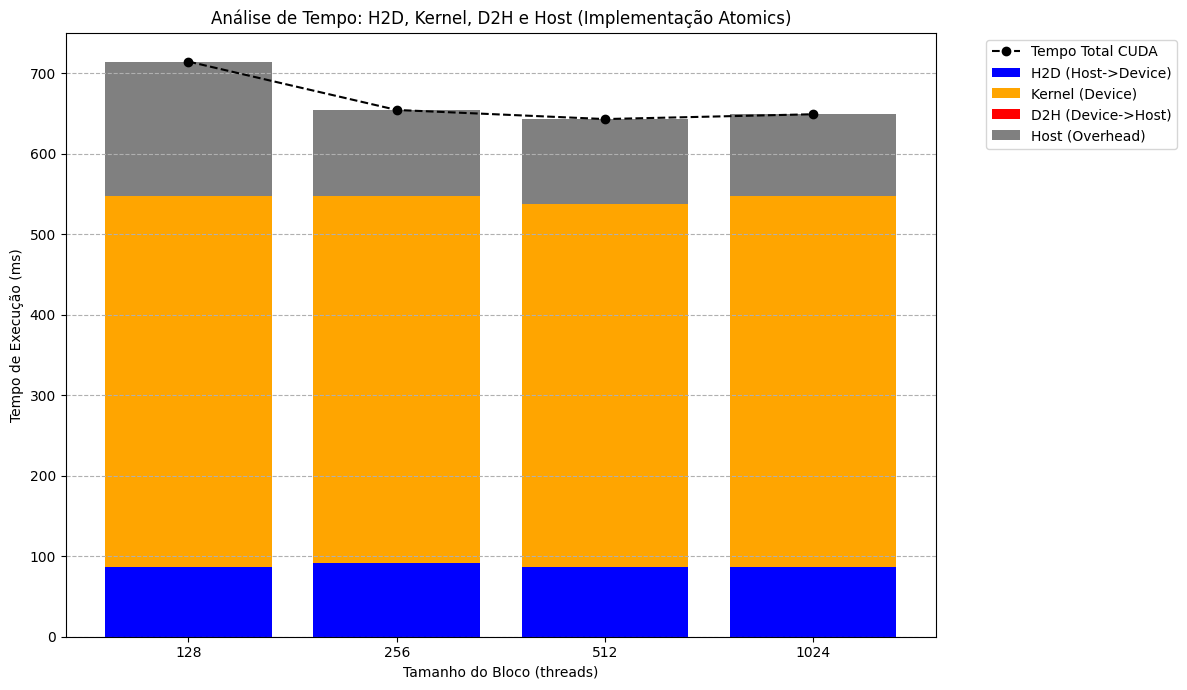

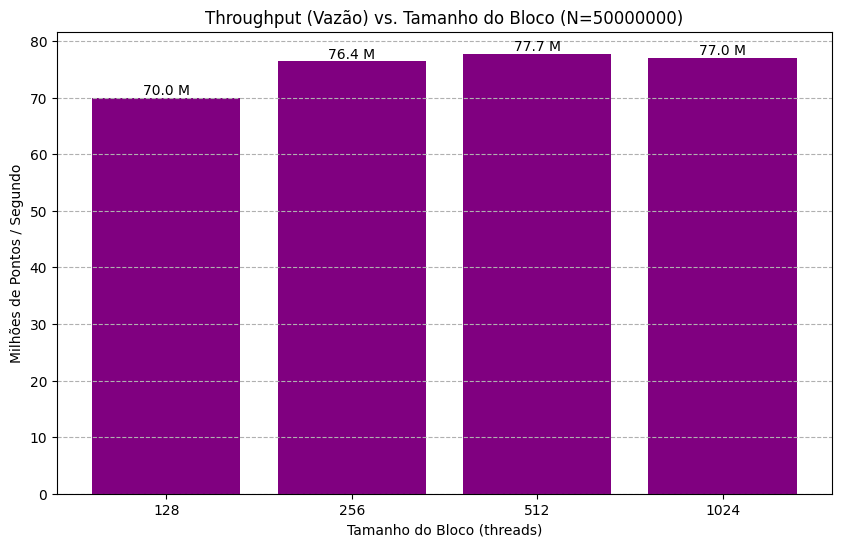


--- Análise Concluída ---
Baseline Sequencial: 3827.2 ms
Melhor CUDA (BS=512): 643.1 ms
Melhor Speedup: 5.95x

--- Tabela de Resultados ---
 Time_ms    SSE_final  Iterations        N  K  BlockSize  Time_H2D_ms  Time_Kernel_ms  Time_D2H_ms  Time_Host_ms  SSE_Match  Speedup  Throughput_MPoints_s
  714.50 191200234.73           3 50000000 16        128        86.00          461.70         0.20        166.60       True     5.36                 69.98
  654.40 191200234.73           3 50000000 16        256        91.90          455.60         0.20        106.60       True     5.85                 76.41
  643.10 191200234.73           3 50000000 16        512        86.80          451.20         0.20        104.90       True     5.95                 77.75
  649.10 191200234.73           3 50000000 16       1024        86.80          460.60         0.10        101.50       True     5.90                 77.03


In [8]:
# 6. SCRIPT DE ORQUESTRAÇÃO, EXECUÇÃO E PLOTAGEM (Versão Limpa para Entrega 2)

# As funções de 'parse_output', 'run_sequential_baseline',
# e 'run_cuda_experiments' são idênticas às da célula anterior.
# Apenas a função 'create_performance_plots' foi modificada
# para remover o Plot 5 (Visualização).

def parse_output(stdout):
    """Parseia as linhas 'FINAL_DATA' e 'SSE_HISTORY' da saída do executável."""
    final_data = {}
    sse_history = []
    final_regex = (
        r"FINAL_DATA: Time=([\d\.]+) SSE=([\d\.]+) Iters=(\d+) N=(\d+) K=(\d+)"
        r"(?: BlockSize=(\d+))?"
        r"(?: Time_H2D=([\d\.]+))?"
        r"(?: Time_Kernel=([\d\.]+))?"
        r"(?: Time_D2H=([\d\.]+))?"
        r"(?: Time_Host=([\d\.]+))?"
    )
    match = re.search(final_regex, stdout)
    if match:
        final_data = {
            "Time_ms": float(match.group(1)),
            "SSE_final": float(match.group(2)),
            "Iterations": int(match.group(3)),
            "N": int(match.group(4)),
            "K": int(match.group(5)),
            "BlockSize": int(match.group(6)) if match.group(6) else 0,
            "Time_H2D_ms": float(match.group(7)) if match.group(7) else 0.0,
            "Time_Kernel_ms": float(match.group(8)) if match.group(8) else 0.0,
            "Time_D2H_ms": float(match.group(9)) if match.group(9) else 0.0,
            "Time_Host_ms": float(match.group(10)) if match.group(10) else 0.0,
        }
    sse_regex = r"SSE_HISTORY: (\d+) ([\d\.]+)"
    for line in stdout.splitlines():
        match_sse = re.search(sse_regex, line)
        if match_sse:
            sse_history.append({
                "iter": int(match_sse.group(1)),
                "sse": float(match_sse.group(2))
            })
    if not final_data:
        print("ERRO: Não foi possível parsear a saída FINAL_DATA.")
    return final_data, sse_history

def run_sequential_baseline():
    """Executa a versão sequencial para obter o tempo de baseline."""
    print("\n--- 1. Executando Baseline Sequencial ---")
    os.makedirs("sequential", exist_ok=True)
    !cp centroides_iniciais.csv centroides_iniciais_seq.csv
    cmd = [
        "./kmeans_1d_naive", "dados.csv", "centroides_iniciais_seq.csv",
        str(MAX_ITER), str(EPSILON), "sequential/assign.csv", "sequential/centroids.csv"
    ]
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, check=True, timeout=600)
        final_data, sse_history = parse_output(result.stdout)
        if not final_data: raise Exception("Parsing do baseline falhou.")
        print(f"Baseline (Sequencial): Tempo={final_data['Time_ms']:.1f} ms, SSE={final_data['SSE_final']:.6f}, Iters={final_data['Iterations']}")
        return final_data, sse_history
    except Exception as e:
        print(f"ERRO ao executar o baseline sequencial: {e}")
        return None, None

def run_cuda_experiments(block_sizes):
    """Executa a versão CUDA com diferentes tamanhos de bloco."""
    print("\n--- 2. Executando Experimentos CUDA ---")
    os.makedirs("cuda_results", exist_ok=True)
    all_results = []
    for bs in block_sizes:
        print(f"Executando CUDA com BlockSize = {bs}...")
        centroids_input_file = f"cuda_results/centroides_iniciais_bs{bs}.csv"
        !cp centroides_iniciais.csv {centroids_input_file}
        assign_file = f"cuda_results/assign_bs{bs}.csv"
        centroids_file = f"cuda_results/centroids_bs{bs}.csv"
        cmd = [
            "./kmeans_1d_cuda", "dados.csv", centroids_input_file, str(bs),
            str(MAX_ITER), str(EPSILON), assign_file, centroids_file
        ]
        try:
            result = subprocess.run(cmd, capture_output=True, text=True, check=True, timeout=600)
            final_data, sse_history = parse_output(result.stdout)
            if final_data:
                all_results.append(final_data)
                print(f"  -> Tempo Total: {final_data['Time_ms']:.1f} ms, SSE: {final_data['SSE_final']:.6f}, Iters: {final_data['Iterations']}")
            else:
                print(f"  -> Falha ao parsear saída para BlockSize={bs}")
        except Exception as e:
            print(f"ERRO ao executar CUDA com BlockSize={bs}: {e}")
    return pd.DataFrame(all_results)

# =============================================================================
# FUNÇÃO DE PLOTAGEM "LIMPA"
# =============================================================================
def create_performance_plots(baseline_data, baseline_sse, cuda_df):
    """
    Gera os gráficos de análise de desempenho para a Etapa 2.
    (Versão "limpa" sem o Plot 5 de visualização)
    """
    print("\n--- 3. Gerando Gráficos de Análise ---")
    os.makedirs("plots", exist_ok=True)

    if cuda_df.empty:
        print("DataFrame CUDA vazio. Pulando plots.")
        return

    # Validar Corretude: Compara SSE
    baseline_sse_final = baseline_data['SSE_final']
    cuda_df['SSE_Match'] = np.isclose(cuda_df['SSE_final'], baseline_sse_final, rtol=1e-3)

    print("\n--- Verificação de Corretude (SSE) ---")
    print(f"SSE Baseline: {baseline_sse_final:.6f}")
    print(cuda_df[['BlockSize', 'SSE_final', 'SSE_Match', 'Iterations']].to_string())

    if not cuda_df['SSE_Match'].all():
        print("\n*** ATENÇÃO: SSE do CUDA não bate com o do baseline! ***\n")

    # Dados do Baseline
    serial_time = baseline_data['Time_ms']
    N = baseline_data['N']
    K = baseline_data['K']

    # Calcular Speedup e Throughput
    cuda_df['Speedup'] = serial_time / cuda_df['Time_ms']
    cuda_df['Throughput_MPoints_s'] = N / (cuda_df['Time_ms'] / 1000.0) / 1_000_000

    # --- Plot 1: (REQUISITO) Convergência SSE ---
    plt.figure(figsize=(10, 6))
    if baseline_sse:
        df_sse = pd.DataFrame(baseline_sse)
        df_sse = df_sse[df_sse['iter'] < baseline_data['Iterations']]
        plt.plot(df_sse["iter"], df_sse["sse"], marker='o', linestyle='-', label="SSE (Baseline Sequencial)")
    plt.title(f"Validação: Convergência do SSE (N={N}, K={K})")
    plt.xlabel("Iteração")
    plt.ylabel("SSE (Soma dos Erros Quadráticos)")
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.savefig("plots/1_validacao_sse.png")
    plt.show()

    # --- Plot 2: (REQUISITO) Speedup vs. Serial ---
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cuda_df['BlockSize'].astype(str), cuda_df['Speedup'], color='green', label='Speedup CUDA')
    plt.bar_label(bars, fmt='%.2fx')
    plt.axhline(y=1, color='r', linestyle='--', label='Baseline Sequencial (Speedup=1)')
    plt.title(f"Speedup vs. Tamanho do Bloco (Baseline={serial_time:.1f} ms)")
    plt.xlabel("Tamanho do Bloco (threads)")
    plt.ylabel("Speedup (Tempo Serial / Tempo CUDA)")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--')
    plt.savefig("plots/2_speedup_vs_blocksize.png")
    plt.show()

    # --- Plot 3: (REQUISITO) Tempos: H2D/D2H, kernel, total ---
    plt.figure(figsize=(12, 7))
    time_h2d = cuda_df['Time_H2D_ms']
    time_kernel = cuda_df['Time_Kernel_ms']
    time_d2h = cuda_df['Time_D2H_ms']
    time_host = cuda_df['Time_Host_ms']
    block_labels = cuda_df['BlockSize'].astype(str)

    plt.bar(block_labels, time_h2d, label='H2D (Host->Device)', color='blue')
    plt.bar(block_labels, time_kernel, bottom=time_h2d, label='Kernel (Device)', color='orange')
    plt.bar(block_labels, time_d2h, bottom=time_h2d + time_kernel, label='D2H (Device->Host)', color='red')
    plt.bar(block_labels, time_host, bottom=time_h2d + time_kernel + time_d2h, label='Host (Overhead)', color='gray')
    plt.plot(block_labels, cuda_df['Time_ms'], marker='o', color='black', linestyle='--', label='Tempo Total CUDA')

    plt.title("Análise de Tempo: H2D, Kernel, D2H e Host (Implementação Atomics)")
    plt.xlabel("Tamanho do Bloco (threads)")
    plt.ylabel("Tempo de Execução (ms)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, axis='y', linestyle='--')
    plt.tight_layout()
    plt.savefig("plots/3_analise_tempo.png")
    plt.show()

    # --- Plot 4: (REQUISITO) Throughput: pontos/s ---
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cuda_df['BlockSize'].astype(str), cuda_df['Throughput_MPoints_s'], color='purple')
    plt.bar_label(bars, fmt='%.1f M')
    plt.title(f"Throughput (Vazão) vs. Tamanho do Bloco (N={N})")
    plt.xlabel("Tamanho do Bloco (threads)")
    plt.ylabel("Milhões de Pontos / Segundo")
    plt.grid(True, axis='y', linestyle='--')
    plt.savefig("plots/4_throughput.png")
    plt.show()

# =============================================================================
# PONTO DE ENTRADA (MAIN)
# =============================================================================
if __name__ == "__main__":

    # Tamanhos de bloco para testar
    block_sizes_to_test = [128, 256, 512, 1024]

    # 1. Executar Baseline
    baseline_data, baseline_sse_history = run_sequential_baseline()

    if baseline_data:
        # 2. Executar CUDA
        cuda_results_df = run_cuda_experiments(block_sizes_to_test)

        # 3. Gerar Gráficos
        if not cuda_results_df.empty:
            create_performance_plots(baseline_data, baseline_sse_history, cuda_results_df)

            print("\n--- Análise Concluída ---")
            print(f"Baseline Sequencial: {baseline_data['Time_ms']:.1f} ms")

            # Encontrar o melhor resultado CUDA
            best_run = cuda_results_df.loc[cuda_results_df['Time_ms'].idxmin()]
            print(f"Melhor CUDA (BS={int(best_run['BlockSize'])}): {best_run['Time_ms']:.1f} ms")
            print(f"Melhor Speedup: {best_run['Speedup']:.2f}x")

            # Imprimir o DataFrame de resultados
            print("\n--- Tabela de Resultados ---")
            print(cuda_results_df.to_string(index=False, float_format="%.2f"))
        else:
            print("Nenhum resultado CUDA foi coletado. Verifique os logs de compilação/execução.")
    else:
        print("Falha ao executar o baseline. Abortando experimentos CUDA.")